# Trabajo práctico integrador - Visión por Computadoras II
## Carrera de Especialización en Inteligencia Artificial - Cohorte 17
### Autores:
* Piñero, Juan Cruz 
* Lloveras, Alejandro
* Méndez, Diego Martín

### Objetivo del trabajo

> Procesar **54305** imágenes de hojas, pertenecientes a **14 especies** de plantas, utilizando modelos de *Computer Vision* para clasificar entre plantas saludables y múltiples enfermedades _**(38 clases en total)**_.

## Inicialización

In [ ]:
# Importación de librerías
# Gestión de archivos y utilidades
import gc
import os
import json
import pickle
import importlib

# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Machine Learning
import keras
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score
from mlflow.metrics import f1_score as mlflow_f1_score
from architectures import VGG_TF

# Librerías propias
from TP_final.dataloading import load_dataloaders
from TP_final import model_evaluation

## Inicialización

# Evaluación de modelos

In [ ]:
models = {}       # Dictionary to hold models
histories = {}    # Dictionary to hold histories
models_metadata = []
# Directory containing your models
model_dir = '.'  # or replace with your path like 'models/'

for filename in os.listdir(model_dir):
    if filename.endswith('.keras'):
        model_name = os.path.splitext(filename)[0]  # Remove .keras extension
        model_path = os.path.join(model_dir, filename)
        # add motdel_path to model_paths array
        models_metadata.append({f'{model_name}':{'model_path':model_path}})

In [ ]:
for metadatas in models_metadata:
    # Each `metadatas` is a dict with a single key-value pair
    model_name, model_metadata = list(metadatas.items())[0]  # Unpack the single item

    history_filename_pkl = model_name + '_history.pkl'
    history_filename_json = model_name + '_history.json'
    
    # first we check if json file exiosts and we load the hsitory   
    if os.path.exists(history_filename_json):
        with open(history_filename_json, 'r') as f:
            history = json.load(f)  
        print(f"✅ Loaded training history for {model_name} from {history_filename_json}")
        
    model_path = model_metadata['model_path']
    history_path = os.path.join(model_dir, history_filename_pkl)

    if os.path.exists(history_filename_pkl):
        with open(history_path, 'rb') as f:
            histories[model_name] = pickle.load(f)
        print(f"✅ Loaded training history for {model_name} from {history_path}")
    else:
        histories[model_name] = None
        print(f"❌ No history found for {model_name} at {history_path}")

✅ Loaded training history for CNN_4_blocks from ./CNN_4_blocks_history.pkl
✅ Loaded training history for model_vgg_10 from ./model_vgg_10_history.pkl
✅ Loaded training history for model_vgg_6 from ./model_vgg_6_history.pkl
✅ Loaded training history for model_vgg_2 from ./model_vgg_2_history.pkl
✅ Loaded training history for model_vgg_4 from ./model_vgg_4_history.pkl


In [49]:
histories

{'CNN_4_blocks': {'accuracy': [0.7525320053100586,
   0.9108967781066895,
   0.9480020403862,
   0.9657490253448486,
   0.9805957078933716,
   0.9851072430610657,
   0.985751748085022,
   0.9867415428161621,
   0.9883298277854919,
   0.9892505407333374],
  'loss': [0.8798957467079163,
   0.29090985655784607,
   0.161028653383255,
   0.104612797498703,
   0.06316506117582321,
   0.0473678782582283,
   0.044437475502491,
   0.04117094352841377,
   0.035449281334877014,
   0.032562486827373505],
  'val_accuracy': [0.13267654180526733,
   0.7445907592773438,
   0.8104225993156433,
   0.8564589023590088,
   0.8875794410705566,
   0.959764301776886,
   0.9675904512405396,
   0.8751496076583862,
   0.9559893012046814,
   0.9443881511688232],
  'val_loss': [8.915430068969727,
   1.0534700155258179,
   0.8487693071365356,
   0.6415500640869141,
   0.3951152563095093,
   0.129608154296875,
   0.0997215285897255,
   0.4474821090698242,
   0.13639171421527863,
   0.20545276999473572]},
 'model_vgg

In [ ]:
def one_hot_to_labels(x):
    return np.argmax(x, axis=1)

metrics = {
    'f1_score': lambda y, p: f1_score(one_hot_to_labels(y), one_hot_to_labels(p), average='macro'),
    'accuracy': lambda y, p: accuracy_score(one_hot_to_labels(y), one_hot_to_labels(p))
}

In [ ]:
vgg_aux =  VGG_TF(38)
preprocess_function_vgg = vgg_aux.preprocess

In [ ]:
# if file csv exists we load it and assign it to results_df 
if os.path.exists('all_models_metrics.csv'):    
    with open('all_models_metrics.csv', 'r') as f:
        df_loaded = pd.read_csv(f, index_col=0)

results_df = df_loaded

In [53]:
models_metadata

[{'CNN_4_blocks': {'model_path': './CNN_4_blocks.keras'}},
 {'model_vgg_10': {'model_path': './model_vgg_10.keras'}},
 {'model_vgg_6': {'model_path': './model_vgg_6.keras'}},
 {'model_vgg_2': {'model_path': './model_vgg_2.keras'}},
 {'model_vgg_4': {'model_path': './model_vgg_4.keras'}}]

In [ ]:
results_df = df_loaded
filtered_models = [model for model in models_metadata if not any(model_name in results_df.index for model_name in model.keys())]
filtered_models

[]

In [ ]:
for idx, metadata in enumerate(filtered_models):

    model_name, model_metadata = list(metadata.items())[0]
    model_path = model_metadata['model_path']

    if 'vgg' not in model_name:
        dataloaders,class_names_train = load_dataloaders(None)
        print('loading dataloader with no preprocessing( no vgg) for model:',model_name)
    else:
        dataloaders,class_names_train = load_dataloaders(preprocess_function_vgg)
    print(f"\n[{idx}] Loading model: {model_path}. with name: {model_name}")
    try:
        # Load model
        model = tf.keras.models.load_model(model_path)

        # Evaluate
        result = recalculate_metrics(model_name, model, dataloaders['test'], metrics)

        # Convert result to DataFrame and append (use index as load order)
        df = pd.DataFrame.from_dict(result, orient='index')
        results_df = pd.concat([results_df, df])

    except Exception as e:
        print(f"Error loading/evaluating {model_path}: {e}")
    
    finally:
        # Clean up to free memory
        tf.keras.backend.clear_session()
        del model
        gc.collect()

print("\nAll models evaluated.")



All models evaluated.


In [56]:
results_df

,f1_score,accuracy,load_index,model_name
CNN_4_blocks,0.956207,0.967590,0.0,CNN_4_blocks
model_vgg_10,0.982002,0.986373,1.0,model_vgg_10
model_vgg_6,0.964518,0.976429,2.0,model_vgg_6
model_vgg_2_augmented_undersampling,0.664821,0.661633,3.0,model_vgg_2_augmented_undersampling
model_vgg_2,0.944423,0.959580,4.0,model_vgg_2
model_vgg_4,0.953030,0.964368,5.0,model_vgg_4
CNN_4_blocks_augmented_undersampling,0.954745,0.960501,NaN,CNN_4_blocks_augmented_undersampling


In [57]:
results_df['model_name'] = results_df.index
results_df

,f1_score,accuracy,load_index,model_name
CNN_4_blocks,0.956207,0.967590,0.0,CNN_4_blocks
model_vgg_10,0.982002,0.986373,1.0,model_vgg_10
model_vgg_6,0.964518,0.976429,2.0,model_vgg_6
model_vgg_2_augmented_undersampling,0.664821,0.661633,3.0,model_vgg_2_augmented_undersampling
model_vgg_2,0.944423,0.959580,4.0,model_vgg_2
model_vgg_4,0.953030,0.964368,5.0,model_vgg_4
CNN_4_blocks_augmented_undersampling,0.954745,0.960501,NaN,CNN_4_blocks_augmented_undersampling


In [58]:
results_df.to_csv('all_models_metrics.csv', index=True)  # Saves with the index


/home/juan/CEIA/vision_computadora_II/TP_final/model_evaluation.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=values, ax=ax, palette=palette);
/home/juan/CEIA/vision_computadora_II/TP_final/model_evaluation.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha="right")
/home/juan/CEIA/vision_computadora_II/TP_final/model_evaluation.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=values, ax=ax, palette=palette);
/home/juan/CEIA/vision_computadora_II/TP_final/model_evaluation.py:153: UserWarning: set_ticklabels() s

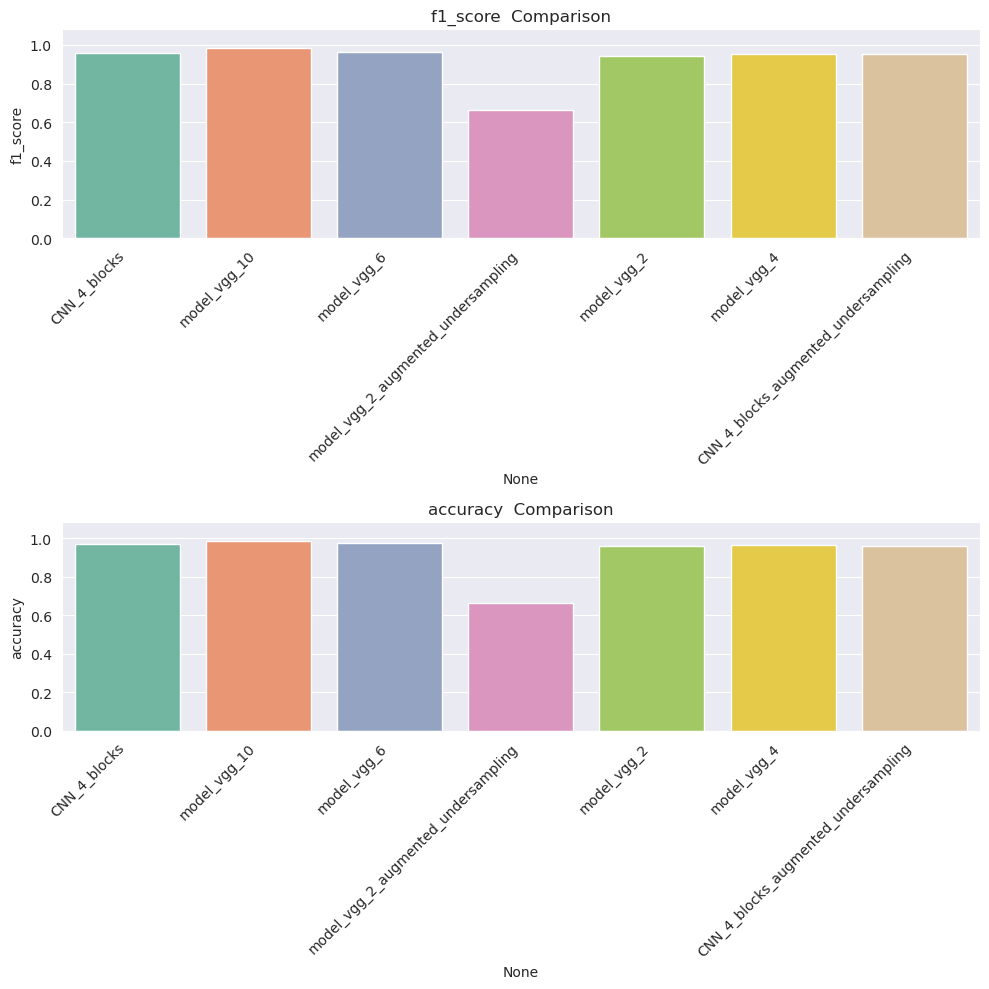

In [ ]:
df_loaded = results_df
# Reload the module
importlib.reload(model_evaluation)
from TP_final.model_evaluation import plot_model_comparison 
plot_model_comparison(df_loaded, ['f1_score','accuracy'])

In [60]:
histories

{'CNN_4_blocks': {'accuracy': [0.7525320053100586,
   0.9108967781066895,
   0.9480020403862,
   0.9657490253448486,
   0.9805957078933716,
   0.9851072430610657,
   0.985751748085022,
   0.9867415428161621,
   0.9883298277854919,
   0.9892505407333374],
  'loss': [0.8798957467079163,
   0.29090985655784607,
   0.161028653383255,
   0.104612797498703,
   0.06316506117582321,
   0.0473678782582283,
   0.044437475502491,
   0.04117094352841377,
   0.035449281334877014,
   0.032562486827373505],
  'val_accuracy': [0.13267654180526733,
   0.7445907592773438,
   0.8104225993156433,
   0.8564589023590088,
   0.8875794410705566,
   0.959764301776886,
   0.9675904512405396,
   0.8751496076583862,
   0.9559893012046814,
   0.9443881511688232],
  'val_loss': [8.915430068969727,
   1.0534700155258179,
   0.8487693071365356,
   0.6415500640869141,
   0.3951152563095093,
   0.129608154296875,
   0.0997215285897255,
   0.4474821090698242,
   0.13639171421527863,
   0.20545276999473572]},
 'model_vgg


📊 Plotting metrics for CNN_4_blocks...


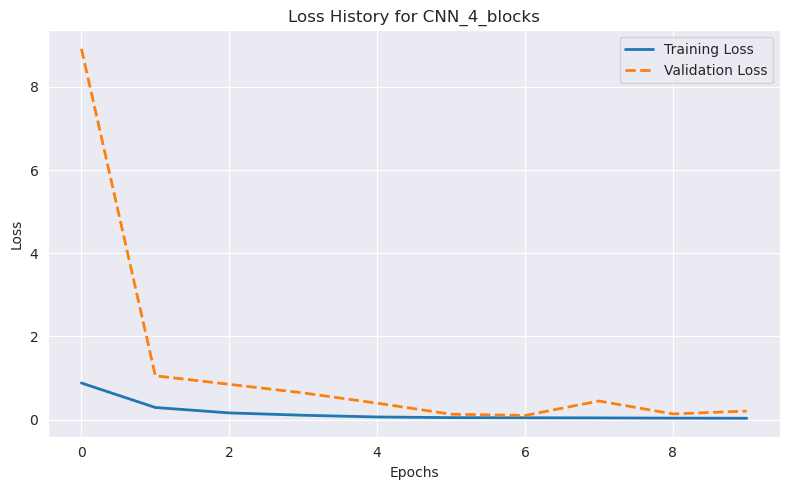

⚠️ No data for metric 'f1_score' in CNN_4_blocks


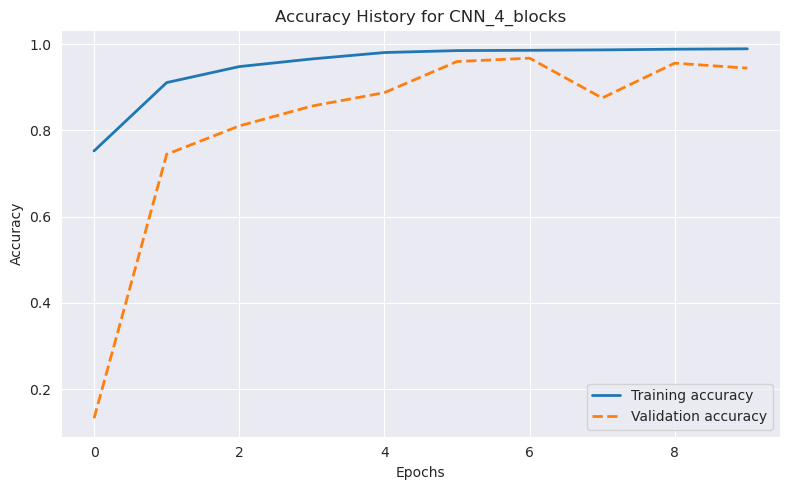


📊 Plotting metrics for model_vgg_10...


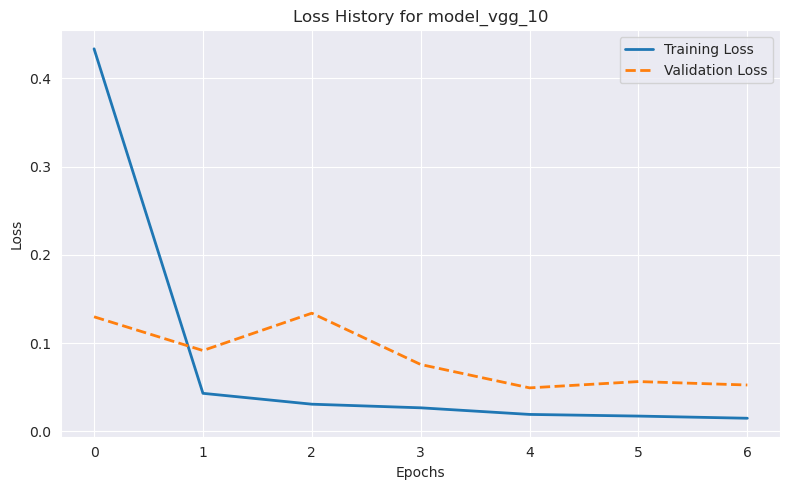

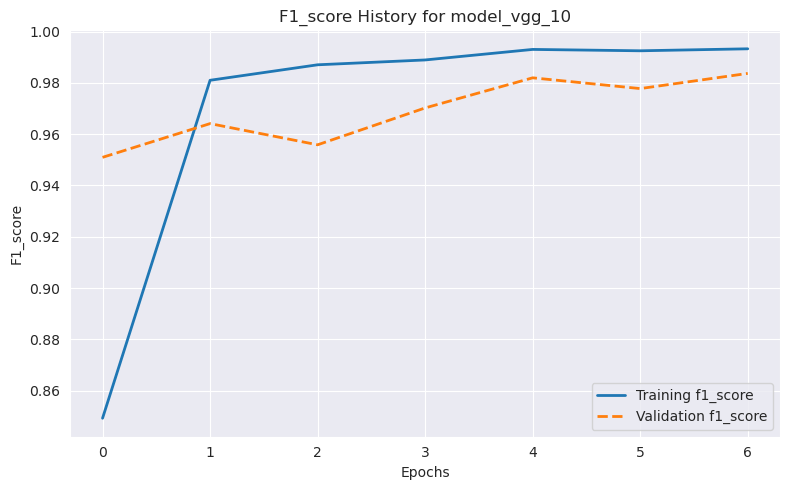

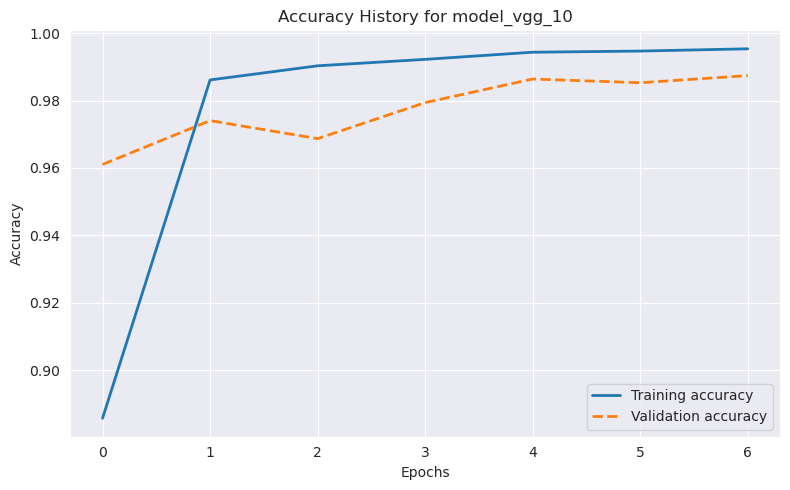


📊 Plotting metrics for model_vgg_6...


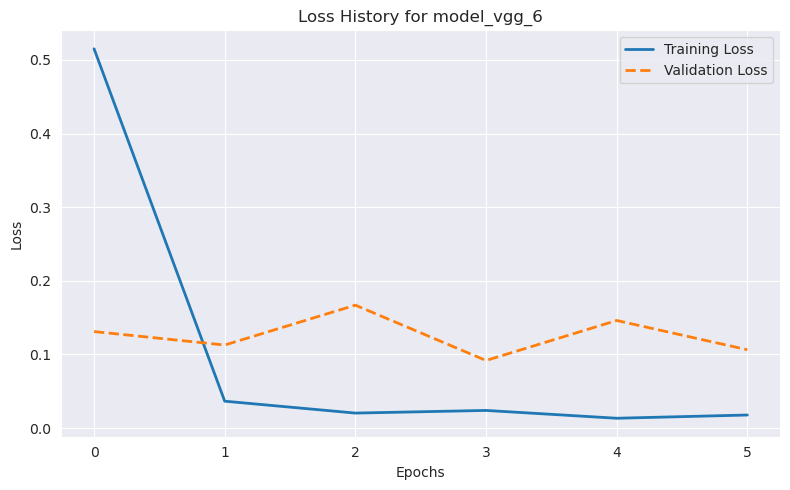

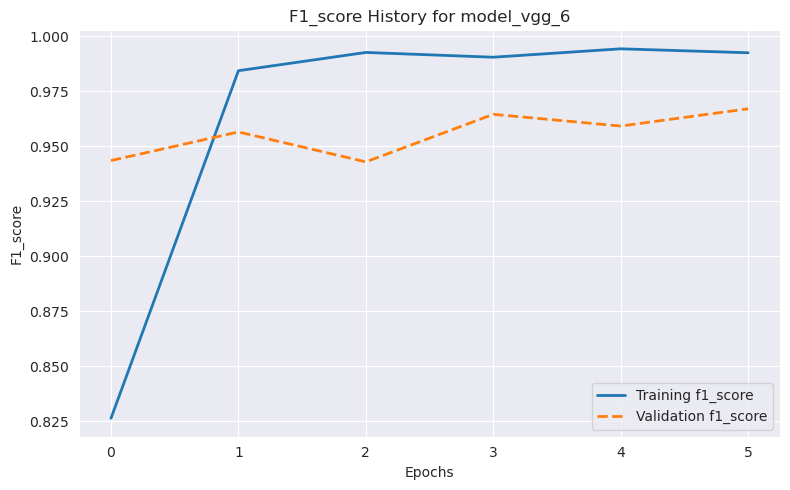

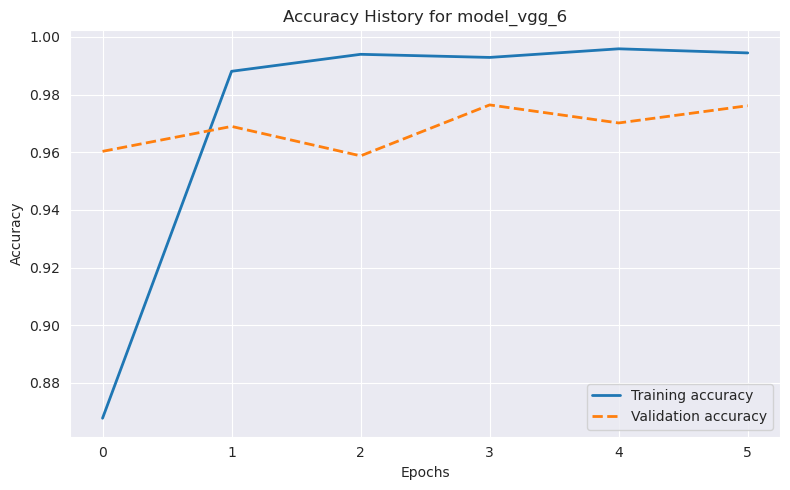


📊 Plotting metrics for model_vgg_2...


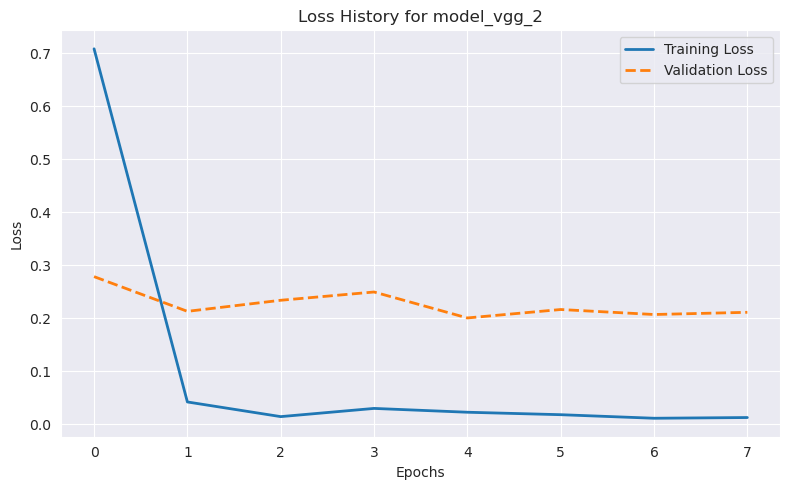

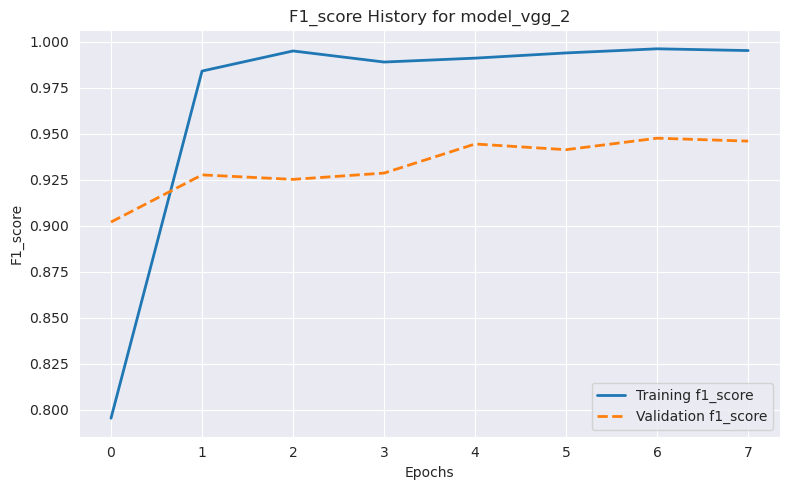

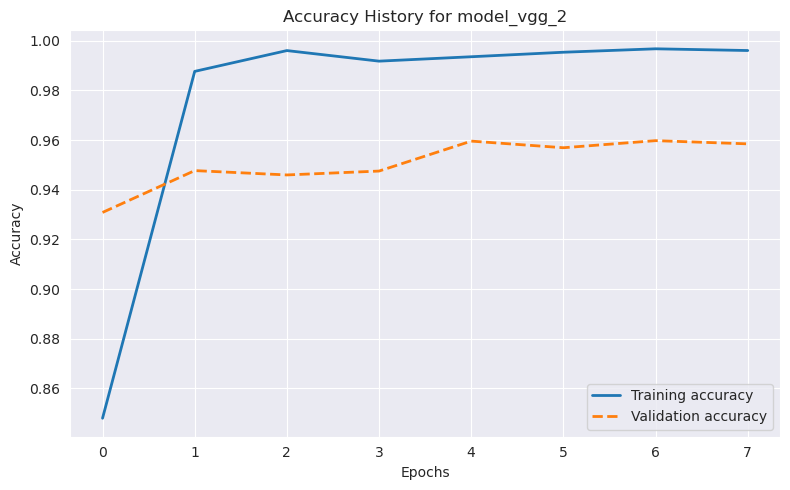


📊 Plotting metrics for model_vgg_4...


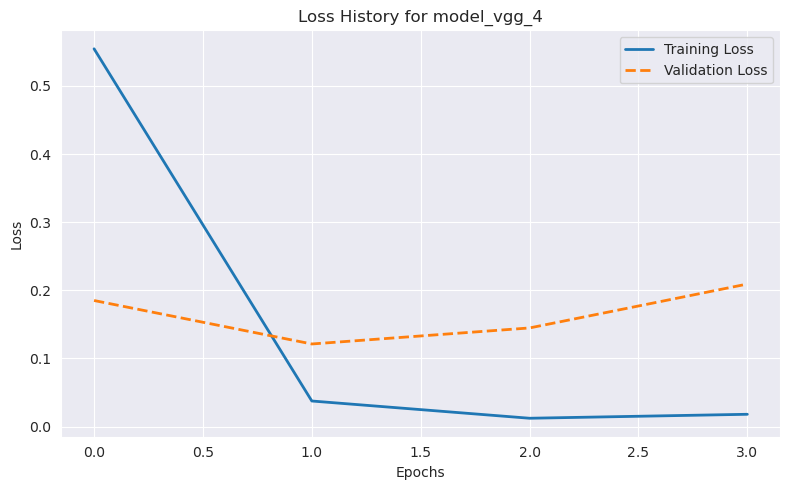

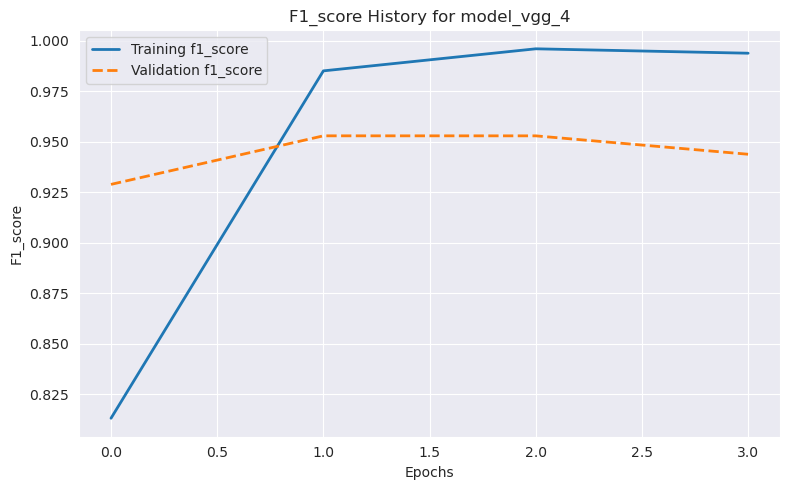

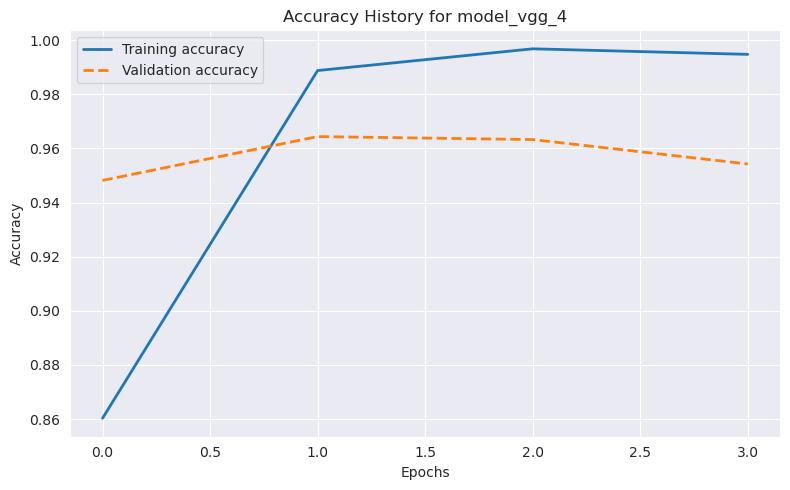

In [ ]:
# Reload the module
importlib.reload(model_evaluation)
from TP_final.model_evaluation import plot_metric_histories 
plot_metric_histories(histories,['loss','f1_score','accuracy'])